In [117]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import numpy as np

In [118]:
data = data_load(data_keys={'bodyport', 'oura_activity', 'oura_sleep'})


In [119]:
data['bodyport']['subsource'].unique()
# subsource is only `weight`

array(['weight'], dtype=object)

In [120]:
data_bodyport = data['bodyport']
users = data_bodyport['user_id'].unique().tolist()
most_data_user = -1
most_data = -1
for u in users:
    num_data = len(data_bodyport[data_bodyport['user_id'] == u])
    if num_data > most_data:
        most_data = num_data
        most_data_user = u
most_data_user
# userid 74 has the most data

74

In [121]:
selected_data_bodyport = data_bodyport[data_bodyport['user_id'] == 74][['date', 'impedance_ratio', 'peripheral_fluid', 'impedance_mag_1_ohms', 'impedance_phase_1_degs', 'weight_kg']].groupby("date", as_index = False).mean()


In [122]:
data_oura_activity = data['oura_activity']
data_oura_activity[data_oura_activity['user_id'] == 74]
data_oura_sleep = data['oura_sleep']

In [123]:
selected_data_oura_activity = data_oura_activity[data_oura_activity['user_id'] == 74][[
 'cal_active',
 'cal_total',
 'daily_movement',
 'high',
 'inactive',
#  'inactivity_alerts',
 'low',
 'medium',
 'met_min_high',
 'met_min_inactive',
 'met_min_low',
 'met_min_medium',
 'non_wear',
 'rest',
#  'rest_mode_state',
#  'score',
#  'score_meet_daily_targets',
#  'score_move_every_hour',
#  'score_recovery_time',
#  'score_stay_active',
#  'score_training_frequency',
#  'score_training_volume',
 'steps',
 'date']]

In [124]:
def get_min_date(df):
    return np.min(df['date'])
def get_max_date(df):
    return np.max(df['date'])

In [125]:

# # union
# overall_min_date = np.min([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
# overall_max_date = np.max([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

# intercept
overall_min_date = np.max([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
overall_max_date = np.min([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

date_range = pd.date_range(overall_min_date, overall_max_date, freq='d')
date_df = pd.DataFrame()
date_df['date'] = date_range
selected_data_bodyport['date'] = selected_data_bodyport['date'].astype('datetime64')
selected_data_oura_activity['date'] = selected_data_oura_activity['date'].astype('datetime64')
selected_data_bodyport = pd.merge(date_df, selected_data_bodyport, how='left')
selected_data_oura_activity = pd.merge(date_df, selected_data_oura_activity, how='left')

unimputed_df = pd.DataFrame()
unimputed_df['date'] = date_range
unimputed_df = pd.merge(unimputed_df, selected_data_bodyport, how='left')
unimputed_df = pd.merge(unimputed_df, selected_data_oura_activity, how='left')

In [154]:
# fill missing days with randomly selected days from previous 14 days window
np.random.seed(90)
activity_mask = selected_data_oura_activity.drop('date', axis=1).isna().all(1)
bodyport_mask = selected_data_bodyport.drop('date', axis=1).isna().all(1)
def random_fill_missing_day(df, mask, window=30):
    if 'date' in df.columns.to_list(): 
        df = df.drop('date', axis=1)
    for i in range(len(mask)):
        if mask[i]:
            if i < window: # do random filling
                available_indice = np.where(mask == False)[0]
                random_observation = df.iloc[np.random.choice(available_indice)]
            else:
                random_index = np.random.randint(low=1, high=window)

                random_observation = df.iloc[i-random_index]
                # print(':',i-random_index)
                # print(i)
                # print(random_index)

            df.iloc[i] = random_observation

    return df
random_filled_oura_activity = random_fill_missing_day(selected_data_oura_activity.drop('date', axis=1), activity_mask)
#np.sum(out.isna().all(1))
random_filled_bodyport = random_fill_missing_day(selected_data_bodyport.drop('date', axis=1), bodyport_mask)
random_filled_oura_activity['date'] = date_range
random_filled_bodyport['date'] = date_range

overall_df = pd.merge(random_filled_oura_activity, random_filled_bodyport, how='left')
overall_df.loc[overall_df['impedance_ratio'] > 10,'impedance_ratio'] = np.nan

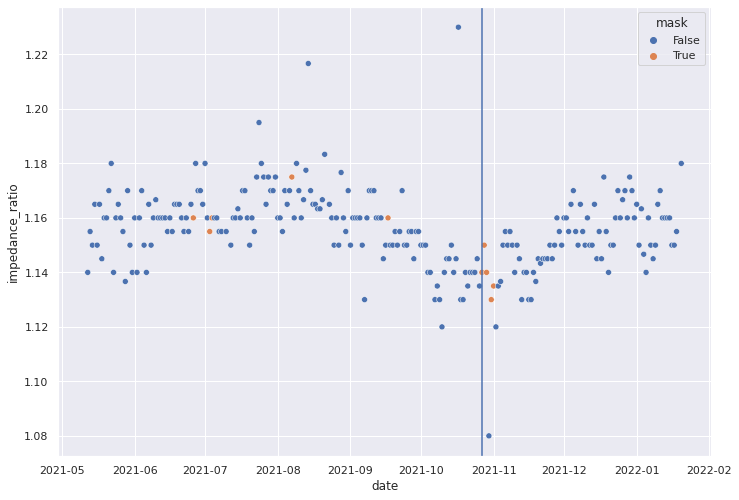

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.scatterplot(x=overall_df["date"], y=overall_df["non_wear"], hue=unimputed_df['non_wear'].isna())
overall_df['mask'] = unimputed_df['impedance_ratio'].isna()
graph = sns.scatterplot(data=overall_df, x="date", y="impedance_ratio", hue="mask")

df_birth = data_load(data_keys={'birth'})['birth']
df_birth[df_birth.user_id == 74].birth_date.values[0]
graph.axvline(pd.to_datetime(df_birth[df_birth.user_id == 74].birth_date.values[0]))

In [156]:
np.sum(overall_df.isna())

cal_active                0
cal_total                 0
daily_movement            0
high                      0
inactive                  0
low                       0
medium                    0
met_min_high              0
met_min_inactive          0
met_min_low               0
met_min_medium            0
non_wear                  0
rest                      0
steps                     0
date                      0
impedance_ratio           5
peripheral_fluid          0
impedance_mag_1_ohms      2
impedance_phase_1_degs    2
weight_kg                 0
mask                      0
dtype: int64

In [128]:
overall_df.describe()

,cal_active,cal_total,daily_movement,high,inactive,low,medium,met_min_high,met_min_inactive,met_min_low,met_min_medium,non_wear,rest,steps,impedance_ratio,peripheral_fluid,impedance_mag_1_ohms,impedance_phase_1_degs,weight_kg
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,253.00000,254.000000,252.000000,252.000000,254.000000
mean,225.338583,1859.976378,5018.661417,0.708661,387.031496,231.464567,26.712598,4.925197,7.692913,141.866142,80.133858,324.220472,465.192913,6553.251969,6.32748,1.728025,573.743386,-6.192427,57.792313
std,149.511152,232.408696,3663.279398,1.464252,204.097587,141.779810,26.126783,9.969832,6.551724,88.572282,79.456987,401.966793,114.302517,4579.332188,47.30267,0.314862,63.343575,0.558396,4.795143
min,0.000000,1389.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.08000,0.000000,284.000000,-12.600000,50.625000
25%,49.750000,1661.000000,1013.250000,0.000000,150.750000,53.000000,3.250000,0.000000,1.000000,30.750000,10.250000,38.250000,429.250000,1155.500000,1.15000,1.610000,539.500000,-6.400000,53.950000
50%,241.000000,1891.500000,5133.500000,0.000000,475.500000,287.500000,18.500000,0.000000,6.000000,165.000000,52.000000,55.000000,504.500000,6696.000000,1.15500,1.675000,594.750000,-6.200000,56.812500
75%,326.750000,2049.000000,7465.750000,1.000000,522.000000,358.000000,40.750000,7.000000,10.000000,204.000000,121.000000,730.500000,528.250000,9591.500000,1.16500,1.853750,618.125000,-5.937500,61.752500
max,696.000000,2508.000000,14997.000000,11.000000,803.000000,448.000000,124.000000,68.000000,21.000000,311.000000,375.000000,1439.000000,745.000000,18878.000000,655.35000,3.520000,700.000000,-4.400000,66.945000


In [162]:
# hyperimpute requires python 3.7
from hyperimpute.plugins.imputers import Imputers
import numpy as np
imputers = Imputers()

imputers.list()
method = 'hyperimpute'
plugin = Imputers().get(method)
X = overall_df.drop('date', axis=1).drop('mask', axis=1)
out = plugin.fit_transform(X.copy())

print(method, out)

hyperimpute      cal_active  cal_total  daily_movement  high  inactive    low  medium  \
0         326.0     2132.0          6159.0   0.0     456.0  359.0    34.0   
1         241.0     2049.0          3635.0   0.0     487.0  358.0    16.0   
2         286.0     1959.0          6559.0   0.0     431.0  193.0    45.0   
3         328.0     1981.0          6824.0   0.0     163.0   51.0    56.0   
4           7.0     1621.0           145.0   0.0      77.0   12.0     0.0   
..          ...        ...             ...   ...       ...    ...     ...   
249       285.0     2008.0          6020.0   3.0     409.0  206.0    39.0   
250       391.0     2178.0          8110.0   0.0     629.0  311.0    55.0   
251       287.0     2036.0          5749.0   1.0     546.0  285.0    41.0   
252       517.0     2310.0         11547.0   1.0     441.0  362.0    87.0   
253       269.0     2038.0          5272.0   1.0     577.0  306.0    25.0   

     met_min_high  met_min_inactive  met_min_low  met_min_mediu

In [158]:
hyperimputed_df_without_date = out
hyperimputed_df_without_date.to_csv('/mnt/results/user_72_activity_bodyport_hyperimpute.csv', index=False, header=False)

In [159]:
hyperimputed_df_without_date['date'] = date_range

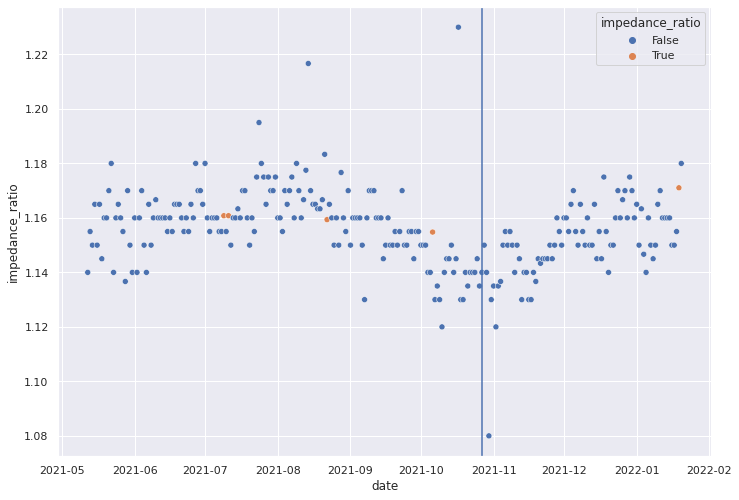

In [161]:
g2 = sns.scatterplot(x=hyperimputed_df_without_date["date"], y=hyperimputed_df_without_date["impedance_ratio"], hue=overall_df['impedance_ratio'].isna())
g2.axvline(pd.to_datetime(df_birth[df_birth.user_id == 74].birth_date.values[0]))

In [141]:
overall_df_without_date = overall_df.drop('date', axis=1)
overall_df_without_date.to_csv('/mnt/results/user_72_activity_bodyport_rand_filled.csv', index=False, header=False)